In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
annots = loadmat('merge_0224_OUsmooth_RL_G4.5_5min_Q100_6.5mW_1Hz.mat')
%matplotlib inline

In [2]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate

In [3]:
## PIfunc that calculate Unique, Synergy and Redundancy of three unsymmetric varibles
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Redun =np.zeros(len(bitshift))
    MIxr=np.zeros(len(bitshift))
    MIvr=np.zeros(len(bitshift))
    MIxvR=np.zeros(len(bitshift))
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        MIxr[i]=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr[i]=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR[i]=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        Redun[i] = sum(np.minimum(PI_xR, PI_vR))/dt
    return timeshift, MIxr, MIvr, MIxvR, Redun

(150, 160)

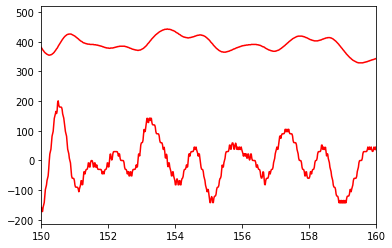

In [4]:
x = np.squeeze(annots['bin_pos'])
x = x.astype(float)
dt = 1./60
T=np.arange(len(x))*dt
v = ndimage.gaussian_filter1d(x, sigma=1, order=1, mode='wrap') / dt
#v = np.diff(x)/dt
x=x[1:-1]
v=v[1:-1] #cut ends.  V(n) = X(n) -X(n-1)
T=T[1:-1]
#plt.plot(T,L[1:-1], 'm-')
plt.plot(T,x, 'r-')
plt.plot(T,v, 'r-')
plt.xlim(150,160)

In [29]:
##response
# Model one: simple estimation
deltaT = 0.5
r1 = x+v*deltaT

# Model Two: negative group delay
# #following paremeters match x+v*0.5s
# alpha = 60.
# beta =  2
# K = 30.
# g = 30.
#following paremeters match x+v*2s
# alpha = 19.9
# beta =  0.62
# K = 10
# g = 30
alpha = 20.
beta =  0.3
K = 20.
g = 30.
y=np.zeros(len(T))
z=np.zeros(len(T))
for j in range(len(T)-1):
    dy=dt*(-alpha*y[j]+K*(x[j]-z[j]))
    dz=dt*(-beta*z[j]+g*y[j])
    y[j+1]=y[j]+dy
    z[j+1]=z[j]+dz

y= y/np.std(y)
r1= r1/np.std(r1)
x = x/np.std(x)
plt.plot(T,y)
plt.plot(T,r1)
plt.plot(T,x)
plt.xlim(260,270)
    
#Chose which one to be response
r = r1

array([9.99999922e-01, 4.24908078e-07, 4.24908078e-07, ...,
       4.34327222e-07, 4.35373794e-07, 4.35373794e-07])

In [6]:
#assign states
edges = np.append(min(r), np.array([np.std(r),2*np.std(r),3*np.std(r)])+np.mean(r));
rstate=np.zeros(len(r))
for i in range(4):
    rstate[r>=edges[i]] = i
rstate = rstate.astype(int)
xstate = EqualState(x, 6)
vstate = EqualState(v, 6)
ystate = EqualState(y, 6)

In [7]:
#calculate information
window = [-2,2] # second
timeshift, MIx, MIv, MIjoint, Redun = PIfunc(rstate, xstate, vstate, dt, window)
Ux = MIx-Redun
Uv = MIv-Redun
Syner = MIjoint-MIx-MIv+Redun

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib

0.6916666666666667

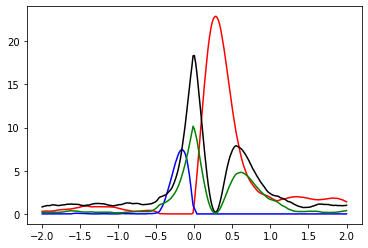

In [8]:
#plot PIs (r,x,v)
plt.plot(timeshift,Ux, 'r-')
plt.plot(timeshift,Uv, 'b-')
plt.plot(timeshift,Syner, 'k-')
plt.plot(timeshift,Redun, 'g-')
x_cor = np.correlate(x, x, "same")
x_cor = x_cor[int((len(x_cor)+1)/2):]
t_cor = (np.where(x_cor < 0.5*x_cor[0])[0][0]-0.5)*dt
t_cor

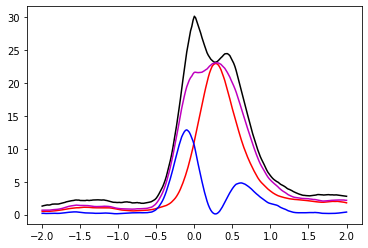

In [9]:
#plot MIs
plt.plot(timeshift,MIx, 'r-')
plt.plot(timeshift,MIv, 'b-')
plt.plot(timeshift,MIjoint, 'k-')
plt.plot(timeshift,MIx+MIv, 'm-')